In [ ]:
#!/usr/bin/env python
"""
Demo for tomography test problem on a large scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.utilities.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.testProblems import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.utilities.helpers import *
from trips.solvers.CGLS import TP_cgls
from trips.solvers.golub_kahan_tikhonov import *
from trips.solvers.GMRES import GMRES
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from trips.utilities.operators import *

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem. Show how the forward operator can be accessed as a matrix (for relatively small problems) or only as an operator.
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [ ]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels that we call views
views = 90
nx = 256
ny = 256
# Step 1: Define the true solution throught the function gen_true(). 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Step 2: Define the forward operator
A = Tomo.forward_Op(x_true, nx, ny, views)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, nx, ny, views)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.01 means 1% additive noise
(b, delta) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)
b_vec = b.reshape((-1,1))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7fde9c822820>)

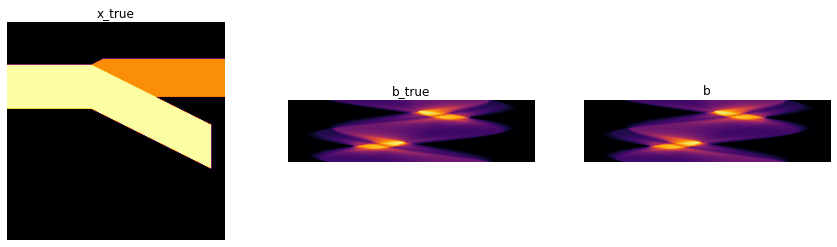

In [ ]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

(-0.5, 361.5, 89.5, -0.5)

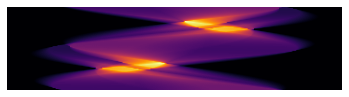

In [ ]:
plt.imshow(b.reshape((p, q)))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

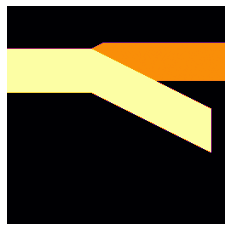

In [ ]:
plt.imshow(x_true.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [ ]:
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=3, n_iter = 50, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta, non_neg = True)

generating basis...:   0%|          | 0/3 [00:00<?, ?it/s]

running GKS...: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


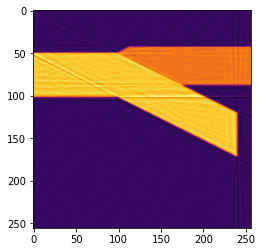

In [ ]:
plt.imshow(x_gks.reshape((nx, ny)))

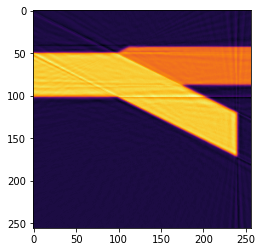

In [ ]:
plt.imshow(x_gks.reshape((nx, ny)))

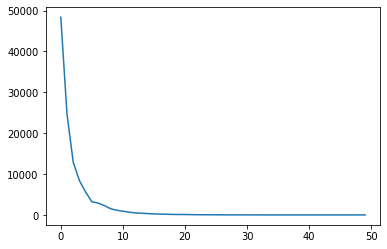

In [ ]:
plt.plot(info_gks['Residual'])

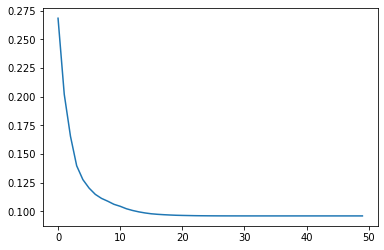

In [ ]:
plt.plot(info_gks['relError'])

In [ ]:
info_gks['relError']

[0.26849842186047207,
 0.20202725365803023,
 0.1654374514790494,
 0.1396204683620246,
 0.12751753477741687,
 0.12010983402379498,
 0.11464386681088039,
 0.11111775045277798,
 0.10868022164020447,
 0.10595632876829668,
 0.10423433912386632,
 0.102090509756588,
 0.10057261801780944,
 0.09936285820809325,
 0.09841799611302098,
 0.0976894973826688,
 0.09722620033713623,
 0.09688742593851485,
 0.09661632182145034,
 0.09638814184112847,
 0.09624743285854274,
 0.0961407899183201,
 0.0960327612841824,
 0.09596462799066532,
 0.09591758615228248,
 0.09588350473073343,
 0.09586058270709054,
 0.09584566255217548,
 0.09583625358743295,
 0.0958288779789653,
 0.09582430864762982,
 0.09582093468838897,
 0.09581911566842222,
 0.09581810507419157,
 0.0958175164600581,
 0.09581740272652113,
 0.095817469965572,
 0.09581770586843234,
 0.0958180451938306,
 0.09581842919338902,
 0.09581881616758406,
 0.09581916481282218,
 0.09581939854744145,
 0.09581953188597589,
 0.095819631014929,
 0.09581970134841412,
 0

In [ ]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 50, regparam = 0, x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


In [ ]:
info_hybrid_lsqr['relError']

[0.40741439351971853,
 0.26843804598504867,
 0.20241704626120713,
 0.16654724657285008,
 0.14157078161672848,
 0.13003612937240577,
 0.12379045989353539,
 0.12192126554451589,
 0.11646463530397387,
 0.11314747097180701,
 0.11111288614380606,
 0.10854923385633869,
 0.10674894764426074,
 0.10459546137774144,
 0.10328407528878317,
 0.10298104538936037,
 0.10173881514165978,
 0.10079097361206041,
 0.09999242256911006]

In [ ]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = Hybrid_LSQR(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)

running Golub-Kahan bidiagonalization algorithm...: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


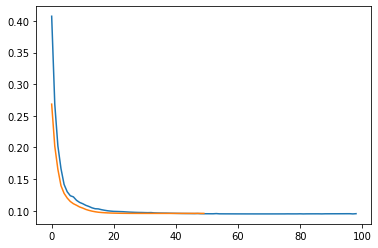

In [ ]:
plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_gks['relError'])

(<matplotlib.image.AxesImage at 0x7fac6bea1730>, (-0.5, 255.5, 255.5, -0.5))

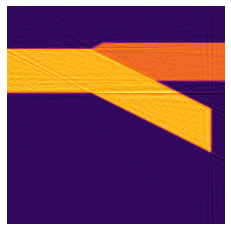

In [ ]:
# x_hybrid_lsqr[x_hybrid_lsqr<0] = 0 # Set the negative values to zero before displaying the image
plt.imshow(x_hybrid_lsqr.reshape((nx, ny))), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7fac6e51a190>, (-0.5, 255.5, 255.5, -0.5))

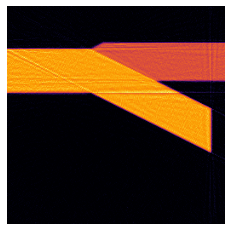

In [ ]:
# x_mmgks[x_mmgks<0] = 0 # Set the negative values to zero before displaying the image
plt.imshow(x_mmgks.reshape((nx, ny))), plt.axis('off')

(<matplotlib.image.AxesImage at 0x7fac6c1f26d0>, (-0.5, 255.5, 255.5, -0.5))

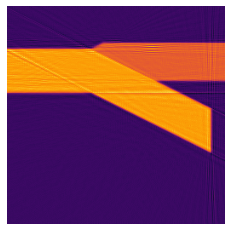

In [ ]:
# x_gks[x_gks<0] = 0 # Set the negative values to zero before displaying the image
plt.imshow(x_gks.reshape((nx, ny))), plt.axis('off')

(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7facde09b9a0>)

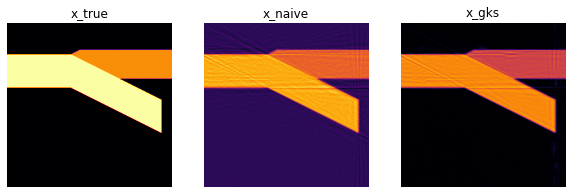

In [ ]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
x_naive[x_naive<0] = 0 # Set the negative values to zero before displaying the image
plt.subplot(1,3,2), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_hybrid_lsqr.reshape((nx,ny)))
x_gks[x_gks<0] = 0 # Set the negative values to zero before displaying the image
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

#### Solve the problem with MMGKS

In [ ]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = gen_first_derivative_operator_2D(nx, ny)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=2, n_iter =50, regparam = 'gcv', x_true = x_true.reshape((-1,1)), delta = delta)

running MMGKS...: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


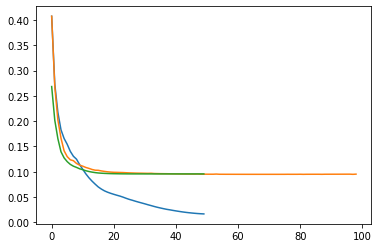

In [ ]:
plt.plot(info_mmgks['relError'])
plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_gks['relError'])

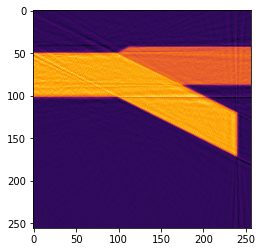

In [ ]:
plt.imshow(x_mmgks.reshape((nx,ny)))

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7facdc97fc40>)

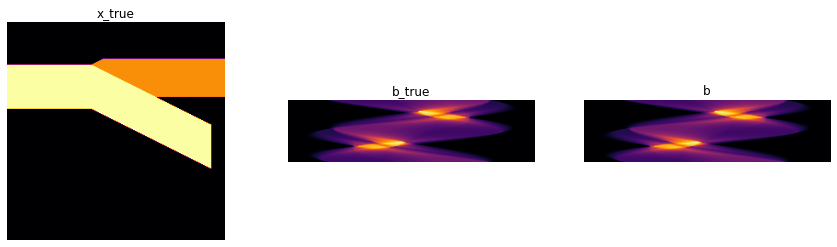

In [ ]:
plt.figure(figsize=(15,4))
plt.set_cmap('inferno')
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

<p> Step 1: Compute a solution Golub-Kahan
<p> Step 2: Compute a solution Golub-Kahan-Tikhonov
<p> Step 2: Compute a solution by GKS


generating basis...: 100%|██████████| 10/10 [00:00<00:00, 327.41it/s]

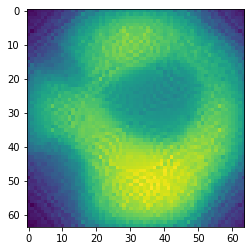

In [ ]:
# Compute a solution Golub-Kahan
projection_dim = 10
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
plt.imshow(x_GKahan.reshape((nx,ny)))

In [ ]:
# Compute a solution Golub-Kahan-Tikhonov
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(A, b.reshape((-1,1)), n_iter = 10, regparam = 'gcv', delta = delta)

generating basis...: 100%|██████████| 3/3 [00:00<00:00, 24.70it/s]


In [123]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 0.001, x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


NameError: name 'x_GKahan' is not defined

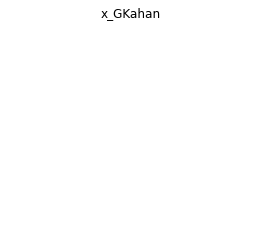

In [4]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_GKahan'), plt.axis('off'), plt.imshow(x_GKahan.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_golub_kahan_tikhonov'), plt.axis('off'), plt.imshow(xgolub_kahan_tikhonov.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))